In [1]:
###########################################################################
#  Image processing to determine image characteristics: edge detection,
# texture and shape analisys, INTENSITY VARIATION, COLOR 
#
# Canada
# August 2019
#
# Oriented by: Dr. M. Shahbazi
# Author: Liége Maldaner
# E-mail: liege.malda@gmail.com
#
# Results:
###########################################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from openpyxl import load_workbook
#import seaborn as sns; sns.set()
from scipy import stats, ndimage
import cv2
import math

#display image larger
def show_pic(img,cmap=None):
    fig = plt.figure(figsize=(15,13))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap)

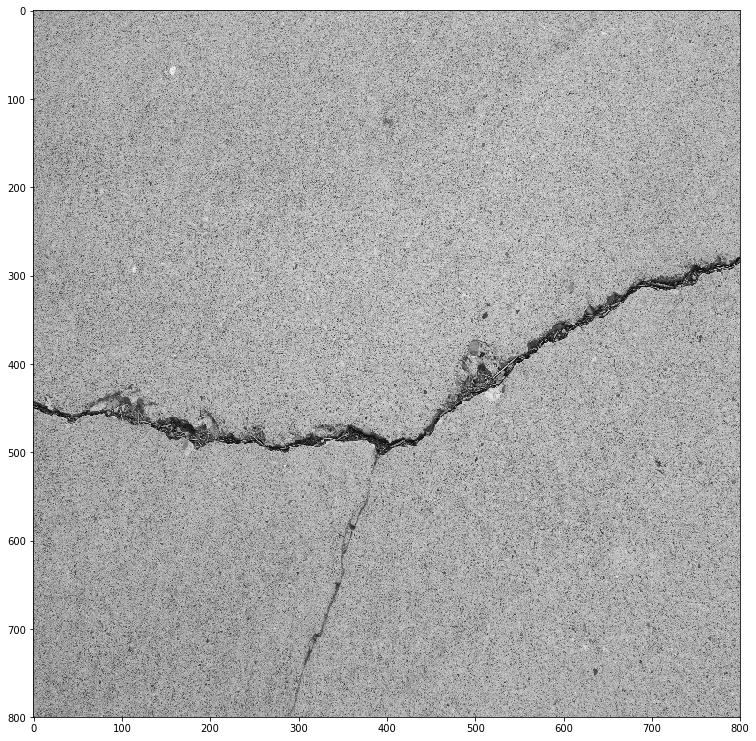

In [2]:
#filename = 'IMG\087' #vertical
#filename = 'IMG\IMG_3620_cut' #horizontal
filename = 'IMG\IMG_3597' #horizontal
#filename = 'IMG\125' #diagonal
#filename = 'IMG\IMG_3638_cut' #diagonal transversal
##filename = 'IMG\IMG_3752_cut' #spaill
#filename = 'IMG\IMG_3795_cut' #spaill
#filename = 'IMG\IMG_3752' #spaill compelete

cracks_resize = cv2.imread(filename+ '.jpg') # IMG_3200.JPG') #   # read crack image
#cracks =cv2.resize(cracks,(1912,1912))   # resize charck image to display
cracks = cv2.resize(cracks_resize,(800,800))   # resize charck image to display
original = cracks.copy()
original_gray = cv2.cvtColor(original,cv2.COLOR_BGR2GRAY) # grayscale image#Noise reduction
#Steerable filter
median = original_gray.copy()

show_pic(median,cmap='gray')

In [3]:
def detection(sigma, image):
    """Detects crack and spaills on the image (horizontal,
    vertical, 45 and -45diagonals)
    
    Implements a steerable Gaussian filter, using the
    method outlined in
        W. T. Freeman and E. H. Adelson, "The Design
        and Use of Steerable Filters", IEEE PAMI, 1991.
    """

    # 1. constructs the 2D gaussian filter "h" given the window size,
    # extrapolated from the "sigma" parameter (4x)
    # Gaussian kernel=\\frac{1}{2\pi\sigma^2}e^\\frac{-(x^2+y^2)}{2\sigma^2}
    winsize = np.ceil(4*sigma) #enough space for the filter
    window = np.arange(-winsize, winsize+1)
    X, Y = np.meshgrid(window, window)
    G = 1.0 / (2*math.pi*sigma**2)
    G *= np.exp(-(X**2 + Y**2) / (2*sigma**2))

    # 2. calculates second derivatives of "G" with respect to "X"
    # (0), "Y" (90 degrees) and 45 degrees
    G2_0 = ((X**2 - sigma**2)/(sigma**4))*G 
    G2_90 = G2_0.T 
    hxy = ((X*Y)/(sigma**4))*G

    # 3. calculates derivatives w.r.t. to all directions of interest 
    # (horizontal, vertical and 2 diagonals)
    # Use steerable filter property of the gaussian kernel (The Design and
    # Use of Steerable Filters" from Freeman and Adelson)
    import scipy
    image_g2_0  = scipy.ndimage.convolve(image, G2_0, mode='nearest')
    image_g2_90 = scipy.ndimage.convolve(image, G2_90, mode='nearest')
    fxy = scipy.ndimage.convolve(image, hxy, mode='nearest')

    # Using the steerable property, we can evaluate the second 
    # derivative like this:    
    # image_g2_45 = image_g2_x*cos^2(45)+2*image_g2_xy*cos(45)*sin(45)+image_g2_y*sin^2(45)
    # image_g2_45 = 0.5*image_g2_x + image_g2_xy + 0.5*image_g2_y

    image_g2_45 = 0.5*image_g2_0 + fxy + 0.5*image_g2_90
    image_g2_m45  = 0.5*image_g2_0 - fxy + 0.5*image_g2_90
    
    #image_g2_m90 = image_g2_0
    
    #Overlap results
    A = np.array(image_g2_0)  
    B = np.array(image_g2_90)  
    C = np.array(image_g2_45)  
    D = np.array(image_g2_m45)
    A = np.asarray(A).reshape(-1)
    B = np.asarray(B).reshape(-1)
    C = np.asarray(A).reshape(-1)
    D = np.asarray(B).reshape(-1)
    A1 = np.maximum(A,B)
    B1 = np.maximum(C,A1)
    C1 = np.maximum(D,B1)
    output = np.reshape(C1,(image.shape[0],-1))

    return output

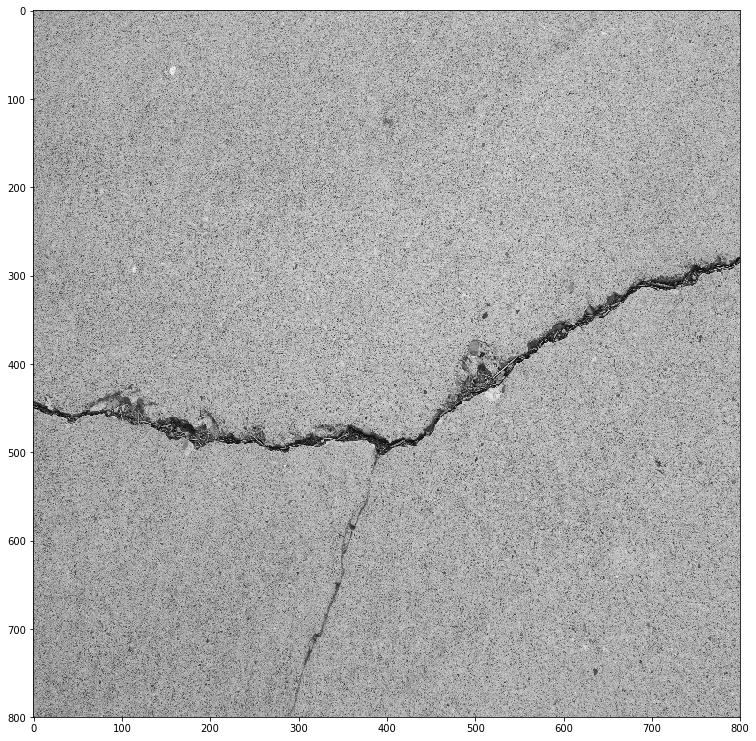

In [4]:
median = original_gray.copy()
show_pic(median,cmap='gray')

provide the kernel lenght: 7


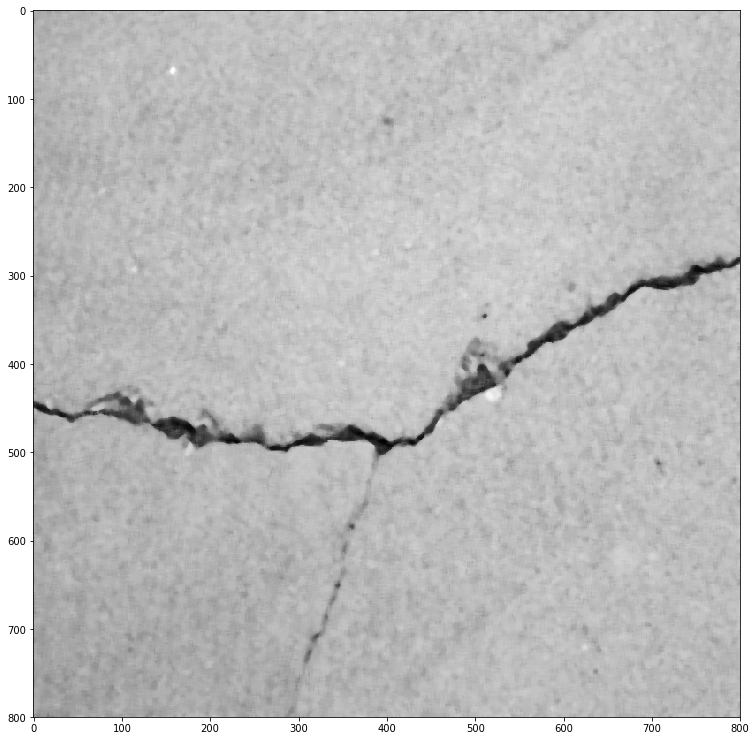

In [5]:
#Median FIlter
median = original_gray.copy()
kernel = input("provide the kernel lenght: ")
median = cv2.medianBlur(median,int(kernel))
show_pic(median,cmap='gray')

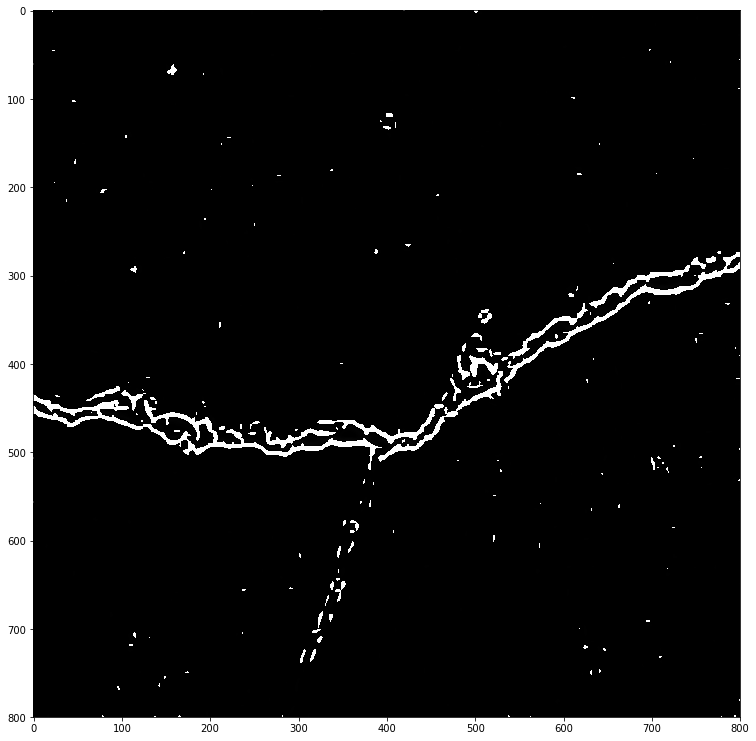

In [6]:
matrix = detection(2,median)
show_pic(matrix,cmap='gray')

In [7]:
'''
#SAVE FINAL IMAGE
from PIL import ImageTk, Image
im = Image.fromarray(cv2.resize(matrix,(750,500)))
#filename = input("provide the image name: ")
filename_spoiled = filename
im.save('images/'+filename_spoiled+'.JPG')  
'''

'\n#SAVE FINAL IMAGE\nfrom PIL import ImageTk, Image\nim = Image.fromarray(cv2.resize(matrix,(750,500)))\n#filename = input("provide the image name: ")\nfilename_spoiled = filename\nim.save(\'images/\'+filename_spoiled+\'.JPG\')  \n'

In [8]:
def Projection_integral(image):
    """
    Shape and texture recognition.
    Implements horizontal PI(HPI), vertical PI (VPI), diagonal PIs (DP1 and DP2) for crack detection. An 
    image containing a spall damage results in PIs which do not have a significant peak of signal 
    and the average value of its SF response is higher than that of an image without defective areas.
    """
    arr = np.asarray(image)
    max_value = 255 * image.shape[0]
    
    #Horizontal PI
    hor = arr.sum(-1) 
    #HPI = hor
    HPI = (hor - hor.min()) / (max_value - hor.min()) #ptp = hor.max - hor.min =  np.ptp(hor)
    
    #Vertical PI
    ver = arr.sum(-2) 
    #VPI = ver
    VPI = (ver - ver.min()) / (max_value - ver.min())
    
    #Diagonal 1 PI
    #sum diagonal pixels
    d1 = np.array([np.trace(arr,offset=i) for i in range(-np.shape(arr)[0]+1, np.shape(arr)[1])])
    x = sum(image[i][i] for i in range(image.shape[0]))
    #only use the middle part (to get the same widht as VPI and HPI)
    d1 = d1[int(image.shape[0]*(1/2)):int(image.shape[0]*(3/2))]
    #get better results on normalization process
    #hlp = np.concatenate((d1,hor[10:len(hor)-10],ver[10:len(ver)-10]), axis=0)
    DPI = (d1 - d1.min()) / (max_value - d1.min()) 
    DPI1 = DPI[0:image.shape[0]]
    
    #Diagonal 2 PI
    im = np.flip(arr, axis=1)
    d2 = np.array([np.trace(im,offset=i) for i in range(-np.shape(im)[0]+1, np.shape(im)[1])])
    d2 = d2[int(image.shape[0]*(1/2)):int(image.shape[0]*(3/2))]
    DPI2 = (d2 - d2.min()) / (max_value - d2.min()) 
    
    return HPI,VPI, DPI1, DPI2

In [15]:
HPI, VPI, DPI1, DPI2  = Projection_integral(matrix)
HPI[0:10] = np.zeros(10, dtype=np.uint8)
HPI[790:799] = np.zeros(9, dtype=np.uint8)
VPI[0:10] = np.zeros(10, dtype=np.uint8)
VPI[790:799] = np.zeros(9, dtype=np.uint8)
#une all vector into one
features = []
features = np.concatenate((HPI, VPI, DPI1, DPI2), axis=0) #SHAPE = [1. 1.] (len(features),)

In [17]:
print(features)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.80392157e-06
 1.47058824e-05 4.90196078e-06]


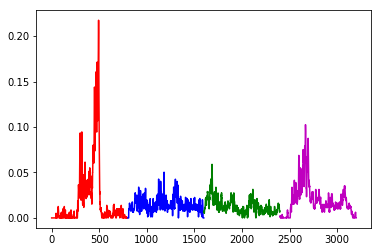

In [10]:
plt.plot(range(799),features[0:799],color='r')
plt.plot(np.arange(800,1599,1),features[800:1599],color='b')
plt.plot(np.arange(1600,2399,1),features[1600:2399],color='g')
plt.plot(np.arange(2400,3199,1),features[2400:3199],color='m')

plt.show()

In [11]:
#USER DEFINE IF IT IS SPALL OR CRACK (Can use probability to do that!)
lista = list(features).copy()
lista.append(float(input("class (0-CRACK, 1-SPALL): ")))

class (0-CRACK, 1-SPALL): 0


In [24]:
#SAVE FEATURES AND CLASSES TO AN EXEL FILE (Sheet1,Sheet2 contain the image name)
xlsFilename = r"C:\Users\Liege Maldaner\Desktop\test.xlsx"
df = pd.DataFrame((features.reshape(1,features.shape[0])))  #SHAPE = [[1. 1.]] (1, len(features))
df1 = pd.DataFrame(filename.split())

book = load_workbook(xlsFilename)
writer = pd.ExcelWriter(xlsFilename, engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

df.to_excel(writer,sheet_name='Sheet1', startrow=writer.sheets['Sheet1'].max_row, index = False,header= False) 
df1.to_excel(writer,sheet_name='Sheet2', startrow=writer.sheets['Sheet2'].max_row, index = False,header= False)
    
writer.save()

In [193]:
#SAVE IMAGE
'''
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.plot(range(799),features[0:799],color='r')
plt.plot(np.arange(800,1599,1),features[800:1599],color='b')
plt.plot(np.arange(1600,2399,1),features[1600:2399],color='g')
plt.plot(np.arange(2400,3199,1),features[2400:3199],color='m')
myfig = filename+'_PI'
plt.savefig('images\ ' + myfig)
'''

"\nimport matplotlib\nmatplotlib.use('Agg')\nimport matplotlib.pyplot as plt\nplt.plot(range(799),features[0:799],color='r')\nplt.plot(np.arange(800,1599,1),features[800:1599],color='b')\nplt.plot(np.arange(1600,2399,1),features[1600:2399],color='g')\nplt.plot(np.arange(2400,3199,1),features[2400:3199],color='m')\nmyfig = filename+'_PI'\nplt.savefig('images\\ ' + myfig)\n"